# Data Analytics Project - Models

# Pair 4 - ASHOKLEY ARIMA Model

---

# 1. Import required modules

In [1]:
import numpy as np
import pandas as pd
from fastai.tabular.core import add_datepart
from pmdarima.arima import auto_arima
from sklearn import metrics

/home/varun487/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


---

# 2. Get Pair 4 Orders Dataset

## 2.1. Get the orders

In [2]:
orders_df = pd.read_csv('../../Preprocess/Pair4/Pair4_orders.csv')
orders_df.head()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
0,2019-05-17,84.500000,83.199997,1.300003,-1.764996,LONG
1,2019-05-20,87.550003,88.849998,-1.299995,-2.747445,LONG
2,2019-05-21,88.250000,83.150002,5.099998,-0.329109,FLAT
3,2019-05-22,87.849998,85.400002,2.449997,-1.330453,FLAT
4,2019-05-23,88.849998,84.849998,4.000000,-0.744760,FLAT


In [3]:
orders_df.tail()

,Date,ASHOKLEY_Close,TATAMTRDVR_Close,Spread,zscore,Orders
57,2019-08-07,61.150002,55.650002,5.500000,-0.177963,FLAT
58,2019-08-08,63.549999,58.750000,4.799999,-0.442469,FLAT
59,2019-08-09,64.300003,58.200001,6.100002,0.048757,FLAT
60,2019-08-13,61.549999,57.700001,3.849998,-0.801441,FLAT
61,2019-08-14,62.549999,57.349998,5.200001,-0.291322,FLAT


## 2.2. Visualize the orders

Text(0, 0.5, 'zscore')

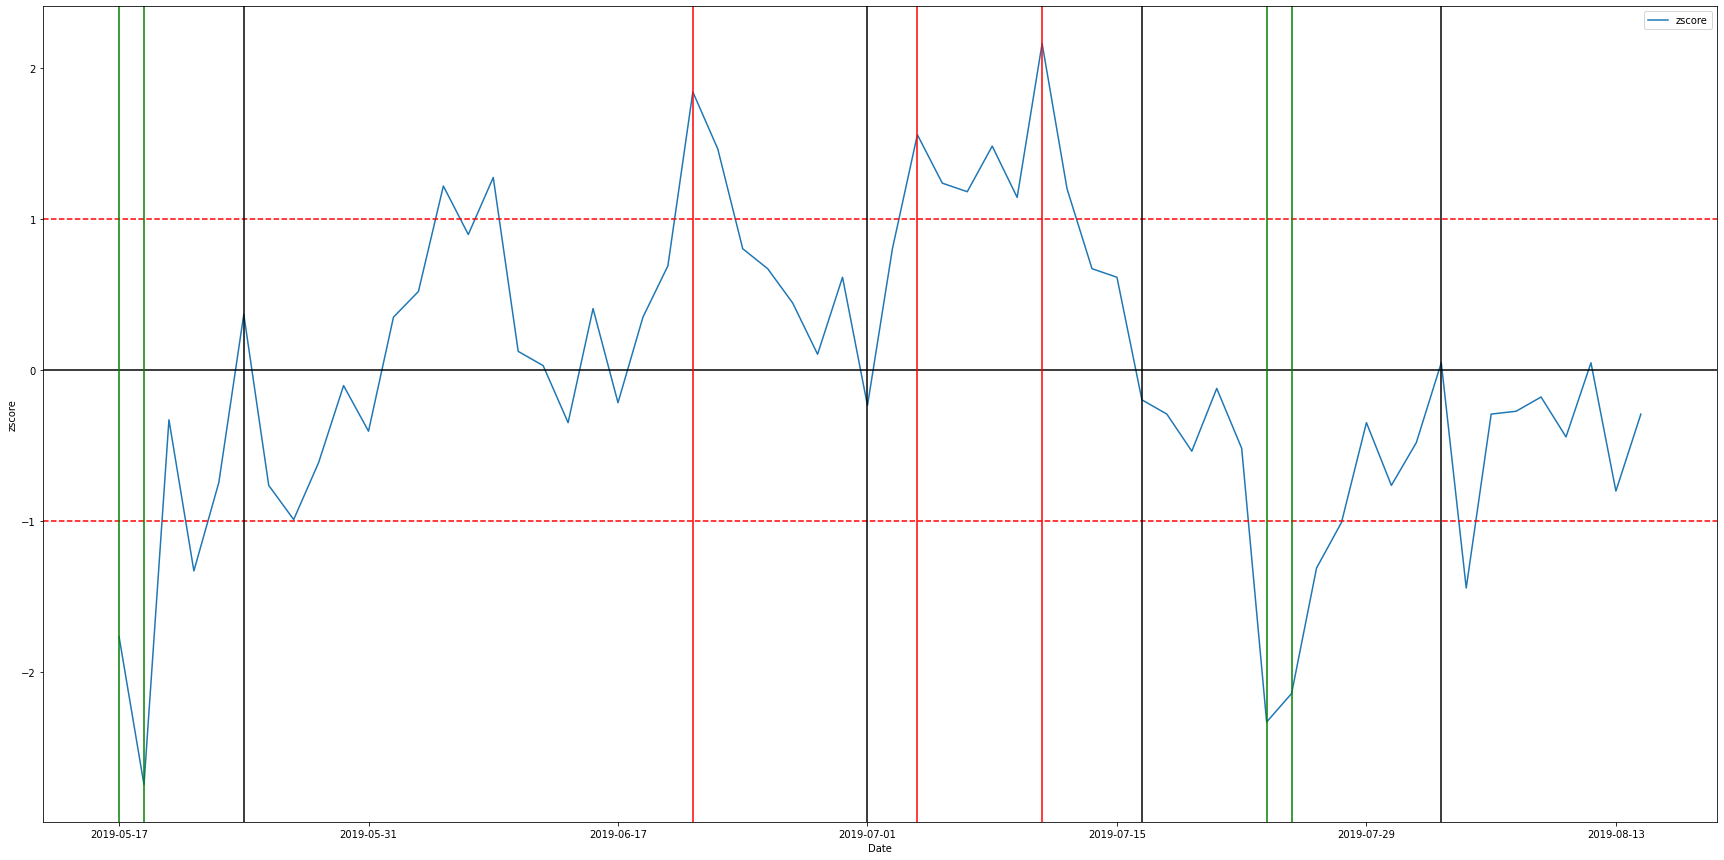

In [4]:
# Plotting the zscore of the Spread
orders_plt = orders_df.plot(x='Date', y='zscore', figsize=(30,15))

# Plotting the lines at mean, 1 and 2 std. dev.
orders_plt.axhline(0, c='black')
orders_plt.axhline(1, c='red', ls = "--")
orders_plt.axhline(-1, c='red', ls = "--")

# Extracting orders
Orders = orders_df['Orders']

# Plot vertical lines where orders are placed
for order in range(len(Orders)):
    
    if Orders[order] != "FLAT":
        
        # GREEN line for a long position
        if Orders[order] == "LONG":
            orders_plt.axvline(x=order, c = "green")
        
        # RED line for a short position
        elif Orders[order] == "SHORT":
            orders_plt.axvline(x=order, c = "red")
        
        # BLACK line for getting out of all positions at that point
        else:
            orders_plt.axvline(x=order, c = "black")

orders_plt.set_ylabel("zscore")

__In the figure above:__
- __Blue line__ - zscore of the Spread
- __Black horizontal line__ at 0 - Mean
- __Red dotted horizontal lines__ - at +1 and -1 standard deviations
- __Green vertical line__ - represents long position taken on that day
- __Red vertical line__ - represents short position taken on that day
- __Black vertical line__ - represents getting out of all open positions till that point


## 2.3 Visualize the close prices of both stocks

Text(0, 0.5, 'Price')

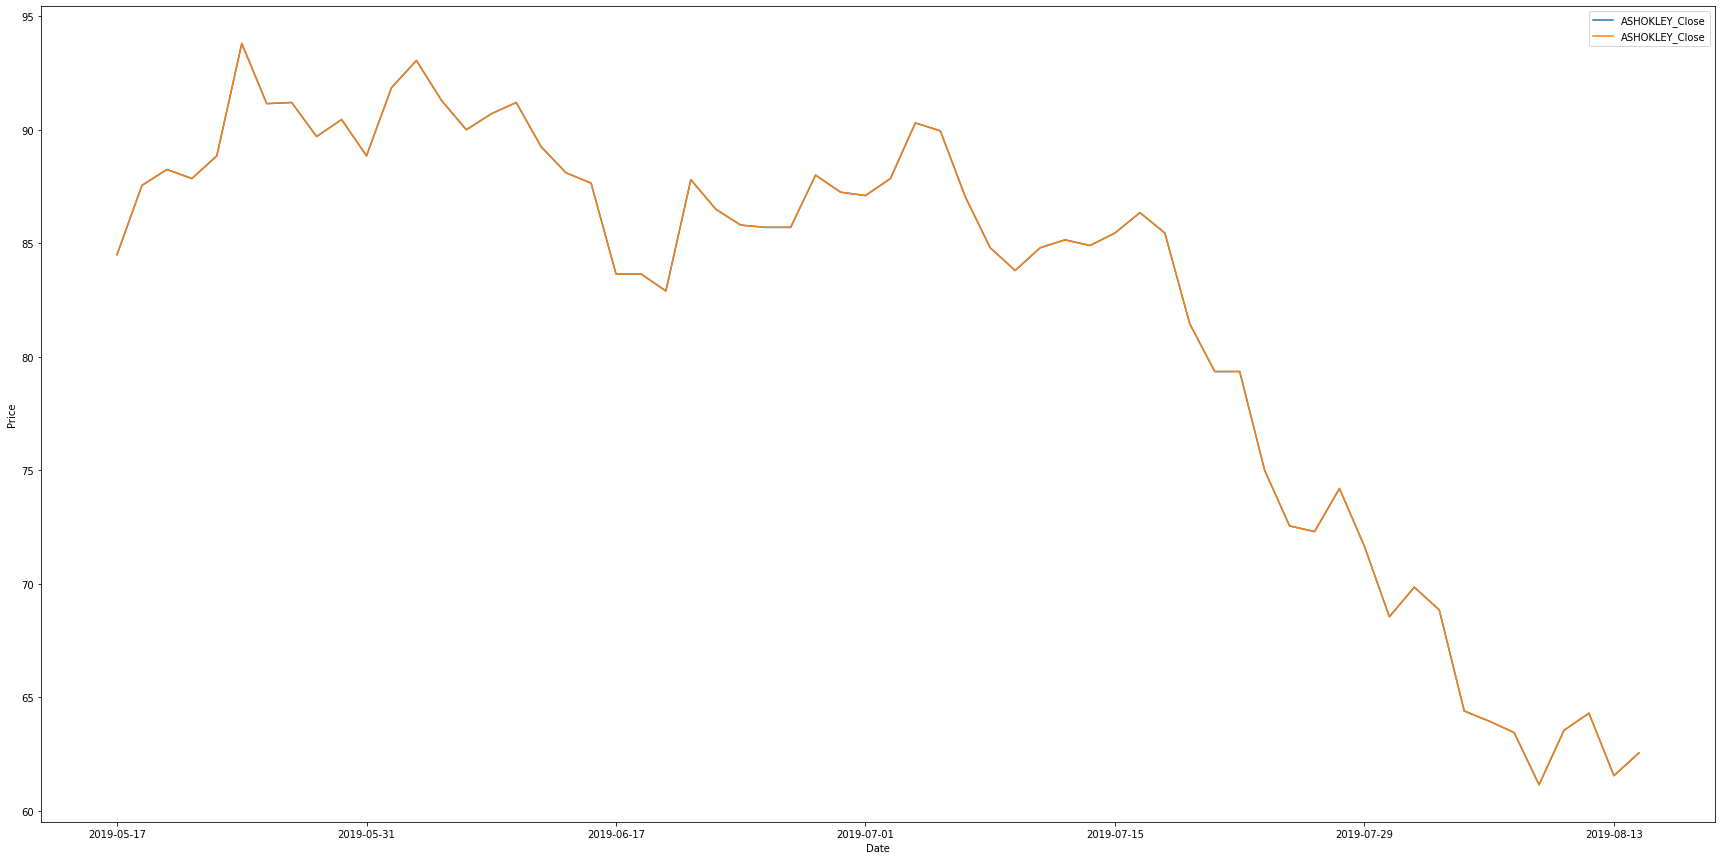

In [5]:
orders_df_plt = orders_df.plot(x='Date', y=['ASHOKLEY_Close', 'ASHOKLEY_Close'], figsize=(30,15))
orders_df_plt.set_xlabel("Date")
orders_df_plt.set_ylabel("Price")

---

# 3. ASHOKLEY Linear Regression Model

## 3.1. Get the Complete ASHOKLEY dataset

In [6]:
tata_df = pd.read_csv("../../Storage/Companies_with_names_exchange/ASHOKLEYNSE.csv")
tata_df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Company,Exchange
0,2017-01-02,81.500000,79.150002,80.500000,81.000000,12823600.0,81.000000,ASHOKLEY,NSE
1,2017-01-03,81.550003,80.449997,81.400002,81.050003,7610206.0,81.050003,ASHOKLEY,NSE
2,2017-01-04,84.550003,81.250000,81.500000,83.849998,14148219.0,83.849998,ASHOKLEY,NSE
3,2017-01-05,84.949997,82.800003,84.650002,83.949997,10474833.0,83.949997,ASHOKLEY,NSE
4,2017-01-06,85.699997,83.150002,84.199997,85.300003,10508449.0,85.300003,ASHOKLEY,NSE


- We can see that we have data from 2017-01-02

## 3.2. Get ASHOKLEY training data

### 3.2.1 Get complete tata dataset

In [7]:
tata_df = tata_df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Company', 'Exchange'])
tata_df.head()

,Date,Close
0,2017-01-02,81.000000
1,2017-01-03,81.050003
2,2017-01-04,83.849998
3,2017-01-05,83.949997
4,2017-01-06,85.300003


- We can see that the period where the stocks are correlated and co-integration starts from 2018-09-04.
- Thus the test data for which we need to make predictions is from 2018-09-04 to when the period ends at 2018-12-03.
- We take 1 year's worth of training data for our model, which means that the time period of our training data is from 2017-09-03 to 2018-09-04.


### 3.2.2. Crop dataset within training range

In [8]:
tata_df_train = tata_df[tata_df['Date'] >= '2017-09-03']
tata_df_train.head()

,Date,Close
166,2017-09-04,113.349998
167,2017-09-05,113.000000
168,2017-09-06,112.150002
169,2017-09-07,111.900002
170,2017-09-08,115.150002


In [9]:
tata_df_train = tata_df_train[tata_df_train['Date'] <= '2018-09-04']
tata_df_train.tail()

,Date,Close
412,2018-08-29,131.899994
413,2018-08-30,130.850006
414,2018-08-31,129.050003
415,2018-09-03,133.449997
416,2018-09-04,127.849998


### 3.2.3 Get the training data and labels

In [10]:
tata_train = tata_df_train.copy()
tata_train

,Date,Close
166,2017-09-04,113.349998
167,2017-09-05,113.000000
168,2017-09-06,112.150002
169,2017-09-07,111.900002
170,2017-09-08,115.150002
...,...,...
412,2018-08-29,131.899994
413,2018-08-30,130.850006
414,2018-08-31,129.050003
415,2018-09-03,133.449997


In [11]:
tata_train = tata_train.reset_index(drop=True)
tata_train = tata_train['Close']
tata_train

0      113.349998
1      113.000000
2      112.150002
3      111.900002
4      115.150002
          ...    
246    131.899994
247    130.850006
248    129.050003
249    133.449997
250    127.849998
Name: Close, Length: 251, dtype: float64

In [12]:
len(tata_train)

251

## 3.3. Get ASHOKLEY Test Data

In [13]:
tata_test_df = orders_df.copy()
tata_test_df = tata_df[(tata_df['Date'] >= '2018-09-04') & (tata_df['Date'] <= '2018-12-03')].copy()
tata_test_df.head()

,Date,Close
416,2018-09-04,127.849998
417,2018-09-05,127.449997
418,2018-09-06,129.699997
419,2018-09-07,132.000000
420,2018-09-10,129.649994


In [14]:
tata_test_df.tail()

,Date,Close
470,2018-11-27,110.300003
471,2018-11-28,108.349998
472,2018-11-29,110.150002
473,2018-11-30,112.349998
474,2018-12-03,107.150002


In [15]:
tata_test = tata_test_df.copy()
tata_test.reset_index(drop=True, inplace=True)
tata_test.index += 251
tata_test.head()

,Date,Close
251,2018-09-04,127.849998
252,2018-09-05,127.449997
253,2018-09-06,129.699997
254,2018-09-07,132.000000
255,2018-09-10,129.649994


In [16]:
tata_test.tail()

,Date,Close
305,2018-11-27,110.300003
306,2018-11-28,108.349998
307,2018-11-29,110.150002
308,2018-11-30,112.349998
309,2018-12-03,107.150002


In [17]:
tata_test = tata_test['Close']

In [18]:
len(tata_test)

59

## 3.4 Create and Train ASHOKLEY Model

In [19]:
model = auto_arima(tata_train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(tata_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1362.389, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1303.580, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.83 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1363.763, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1280.241, Time=0.94 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1278.245, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1301.718, Time=0.20 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.58 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1280.241, Time=0.94 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=7.91 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=1280.220, T

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

## 3.5. Get predictions

In [20]:
forecast = model.predict(n_periods=len(tata_test))
forecast = pd.DataFrame(forecast, index = tata_test.index, columns=['Prediction'])
forecast

,Prediction
251,128.025796
252,127.611621
253,129.149894
254,123.576205
255,120.873591
256,123.130803
257,125.468585
258,127.685458
259,125.899847
260,125.286237


In [21]:
predictions = forecast['Prediction']
print('Mean Absolute Error:', metrics.mean_absolute_error(tata_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(tata_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(tata_test, predictions)))

Mean Absolute Error: 14.596826363809276
Mean Squared Error: 283.7682122228967
Root Mean Squared Error: 16.84542110553775


## 3.6. Visualize the predicitons vs test data

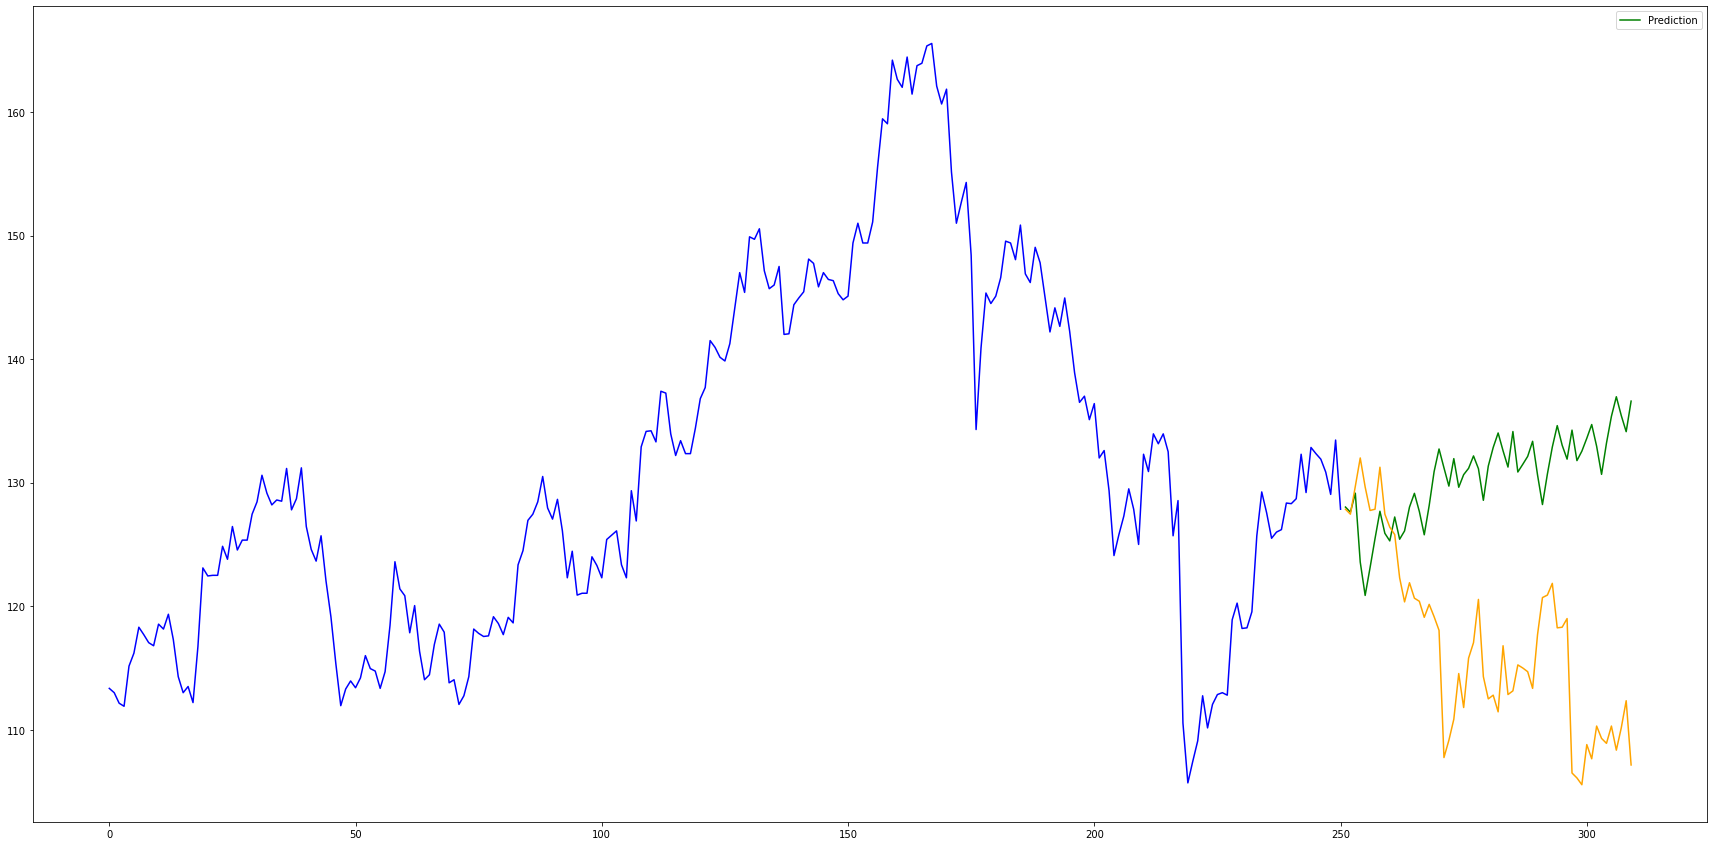

In [22]:
tata_model_plt = forecast.plot(y=['Prediction'], figsize=(30,15), c='green')
tata_model_plt.plot(tata_train, c='blue')
tata_model_plt.plot(tata_test, c='orange')

__In the graph above:__
- We can see the training data in blue
- The test data in orange
- The predictions made by the models in green

# 4. Put the results in a file

In [23]:
tata_predictions_df = pd.read_csv('Tata_predicitions.csv')
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close
0,2019-05-17,83.199997,145.655884
1,2019-05-20,88.849998,145.384391
2,2019-05-21,83.150002,145.112899
3,2019-05-22,85.400002,144.841406
4,2019-05-23,84.849998,143.197024


In [24]:
forecast = forecast.reset_index()
forecast = forecast.drop(columns='index')
tata_predictions_df['ARIMA_Close'] = forecast['Prediction']
tata_predictions_df.head()

,Date,Actual_Close,Linear_regression_Close,ARIMA_Close
0,2019-05-17,83.199997,145.655884,128.025796
1,2019-05-20,88.849998,145.384391,127.611621
2,2019-05-21,83.150002,145.112899,129.149894
3,2019-05-22,85.400002,144.841406,123.576205
4,2019-05-23,84.849998,143.197024,120.873591


In [25]:
tata_predictions_df.to_csv('Tata_predicitions.csv', index=False)